#  Introduction
link https://www.kaggle.com/datasets/avineshprabhakaran/loan-eligibility-prediction/data

Loan approval is a critical decision-making task in the banking and financial sector.  
Each applicant is evaluated based on demographic, financial, and credit-related attributes to estimate their repayment capability and overall risk.

In this notebook, we work with the **Loan Eligibility Prediction Dataset**, which includes information such as income details, employment status, dependents, credit history, loan amount requested, and other essential features.

Our objective is to:
- Explore and understand the dataset  
- Perform preprocessing and feature engineering  
- Build and evaluate machine learning models  
- Predict whether an applicant is eligible for loan approval  

This notebook provides an end-to-end workflow for solving a real-world financial classification problem.


## Imports

In [31]:
!pip install catboost -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.5 MB/s eta 0:00:00


In [32]:
import kagglehub
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier



## Load The Data

In [2]:
# Download latest version
path = kagglehub.dataset_download("avineshprabhakaran/loan-eligibility-prediction")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'loan-eligibility-prediction' dataset.
Path to dataset files: /kaggle/input/loan-eligibility-prediction


In [3]:
print(os.listdir(path))

['Loan Eligibility Prediction.csv']


In [4]:
df = pd.read_csv(os.path.join(path,'Loan Eligibility Prediction.csv'))

## Explore The Data

In [5]:
df.head()

,Customer_ID,Gender,Married,Dependents,Education,Self_Employed,Applicant_Income,Coapplicant_Income,Loan_Amount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,569,Female,No,0,Graduate,No,2378,0.0,9,360,1,Urban,N
1,15,Male,Yes,2,Graduate,No,1299,1086.0,17,120,1,Urban,Y
2,95,Male,No,0,Not Graduate,No,3620,0.0,25,120,1,Semiurban,Y
3,134,Male,Yes,0,Graduate,Yes,3459,0.0,25,120,1,Semiurban,Y
4,556,Male,Yes,1,Graduate,No,5468,1032.0,26,360,1,Semiurban,Y


In [6]:
df.isna().sum().sum()

np.int64(0)

In [7]:
df.duplicated().sum()

np.int64(0)

In [8]:
df.shape

(614, 13)

## Preprocessing

In [9]:
df['Gender'] = df['Gender'].apply(lambda x:1 if x == 'Male' else 0)
df['Married'] = df['Married'].apply(lambda x:1 if x == 'Yes' else 0)
df['Self_Employed'] = df['Self_Employed'].apply(lambda x:1 if x == 'Yes' else 0)
df['Loan_Status'] = df['Loan_Status'].apply(lambda x:1 if x == 'Y' else 0)


In [10]:
print(df['Gender'].value_counts())
print(df['Married'].value_counts())
print(df['Self_Employed'].value_counts())
print(df['Loan_Status'].value_counts())

Gender
1    499
0    115
Name: count, dtype: int64
Married
1    399
0    215
Name: count, dtype: int64
Self_Employed
0    523
1     91
Name: count, dtype: int64
Loan_Status
1    422
0    192
Name: count, dtype: int64


In [11]:
cat = ['Education','Property_Area']

dummy = pd.get_dummies(df[cat]).astype(int)
df = pd.concat([df,dummy],axis=1)
df = df.drop(cat,axis=1)

In [17]:
df = df.drop('Customer_ID',axis=1)

In [18]:
df.head()

,Gender,Married,Dependents,Self_Employed,Applicant_Income,Coapplicant_Income,Loan_Amount,Loan_Amount_Term,Credit_History,Loan_Status,Education_Graduate,Education_Not Graduate,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,0,0,0,0,2378,0.0,9,360,1,0,1,0,0,0,1
1,1,1,2,0,1299,1086.0,17,120,1,1,1,0,0,0,1
2,1,0,0,0,3620,0.0,25,120,1,1,0,1,0,1,0
3,1,1,0,1,3459,0.0,25,120,1,1,1,0,0,1,0
4,1,1,1,0,5468,1032.0,26,360,1,1,1,0,0,1,0


## Exploratory Data Analysis Summary

### 1. Correlation Heatmap
The correlation heatmap shows the linear relationships between numerical and encoded categorical features.  
Key observations:
- **Applicant_Income** and **Loan_Amount** show a moderate positive correlation.
- **Credit_History** has a noticeable positive relationship with **Loan_Status**, indicating that applicants with a good credit history are more likely to get loan approval.
- Most other features show weak or near-zero correlation, suggesting they contribute non-linearly or interactively.

---

### 2. Distribution of Loan_Status
The target variable is imbalanced:
- Loan approved (1): higher count  
- Loan not approved (0): lower count  
This slight imbalance may require careful model evaluation but is still manageable with standard classifiers.

---

### 3. Box Plots for Numerical Features
Box plots help detect outliers and understand data spread.

#### • Applicant_Income  
- Contains many high-income outliers.
- Distribution is right-skewed, typical for financial datasets.

#### • Coapplicant_Income  
- Shows extreme outliers, indicating some applicants have unusually high co-applicant incomes.

#### • Loan_Amount  
- Contains several high-value outliers.
- Median loan amount lies near the lower range.

#### • Loan_Amount_Term  
- Mostly concentrated around certain fixed values (e.g., 360 months).
- A few outliers represent unusual loan term durations.

#### • Education Features  
- Since these are encoded (0/1), box plots show binary variation only.
- No real numerical distribution, just category representation.

---

###  Overall Insights
- Income-related columns have substantial outliers, which may require **scaling** or **robust transformation**.
- Credit history stands out as an important feature for predicting loan eligibility.
- Target variable is slightly imbalanced but not severely.
- Many features have low correlation with Loan_Status, so **non-linear models** may perform better.



### Correlation Heatmap


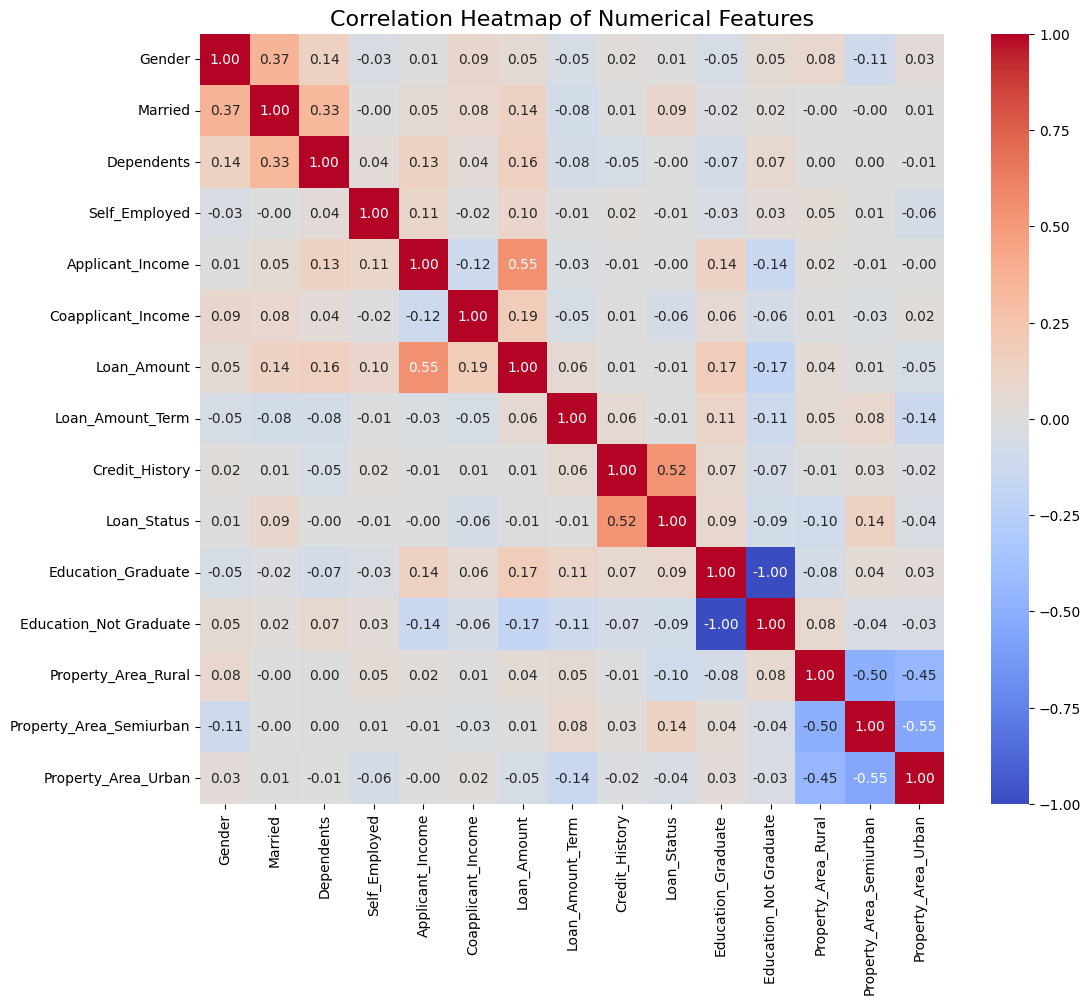

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select numerical columns, excluding 'Customer_ID'
numerical_df = df.select_dtypes(include=np.number).drop(columns=['Customer_ID'])

# Calculate the correlation matrix
corr_matrix = numerical_df.corr()

# Create the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Features', fontsize=16)
plt.show()

### Outlier Distribution Box Plots


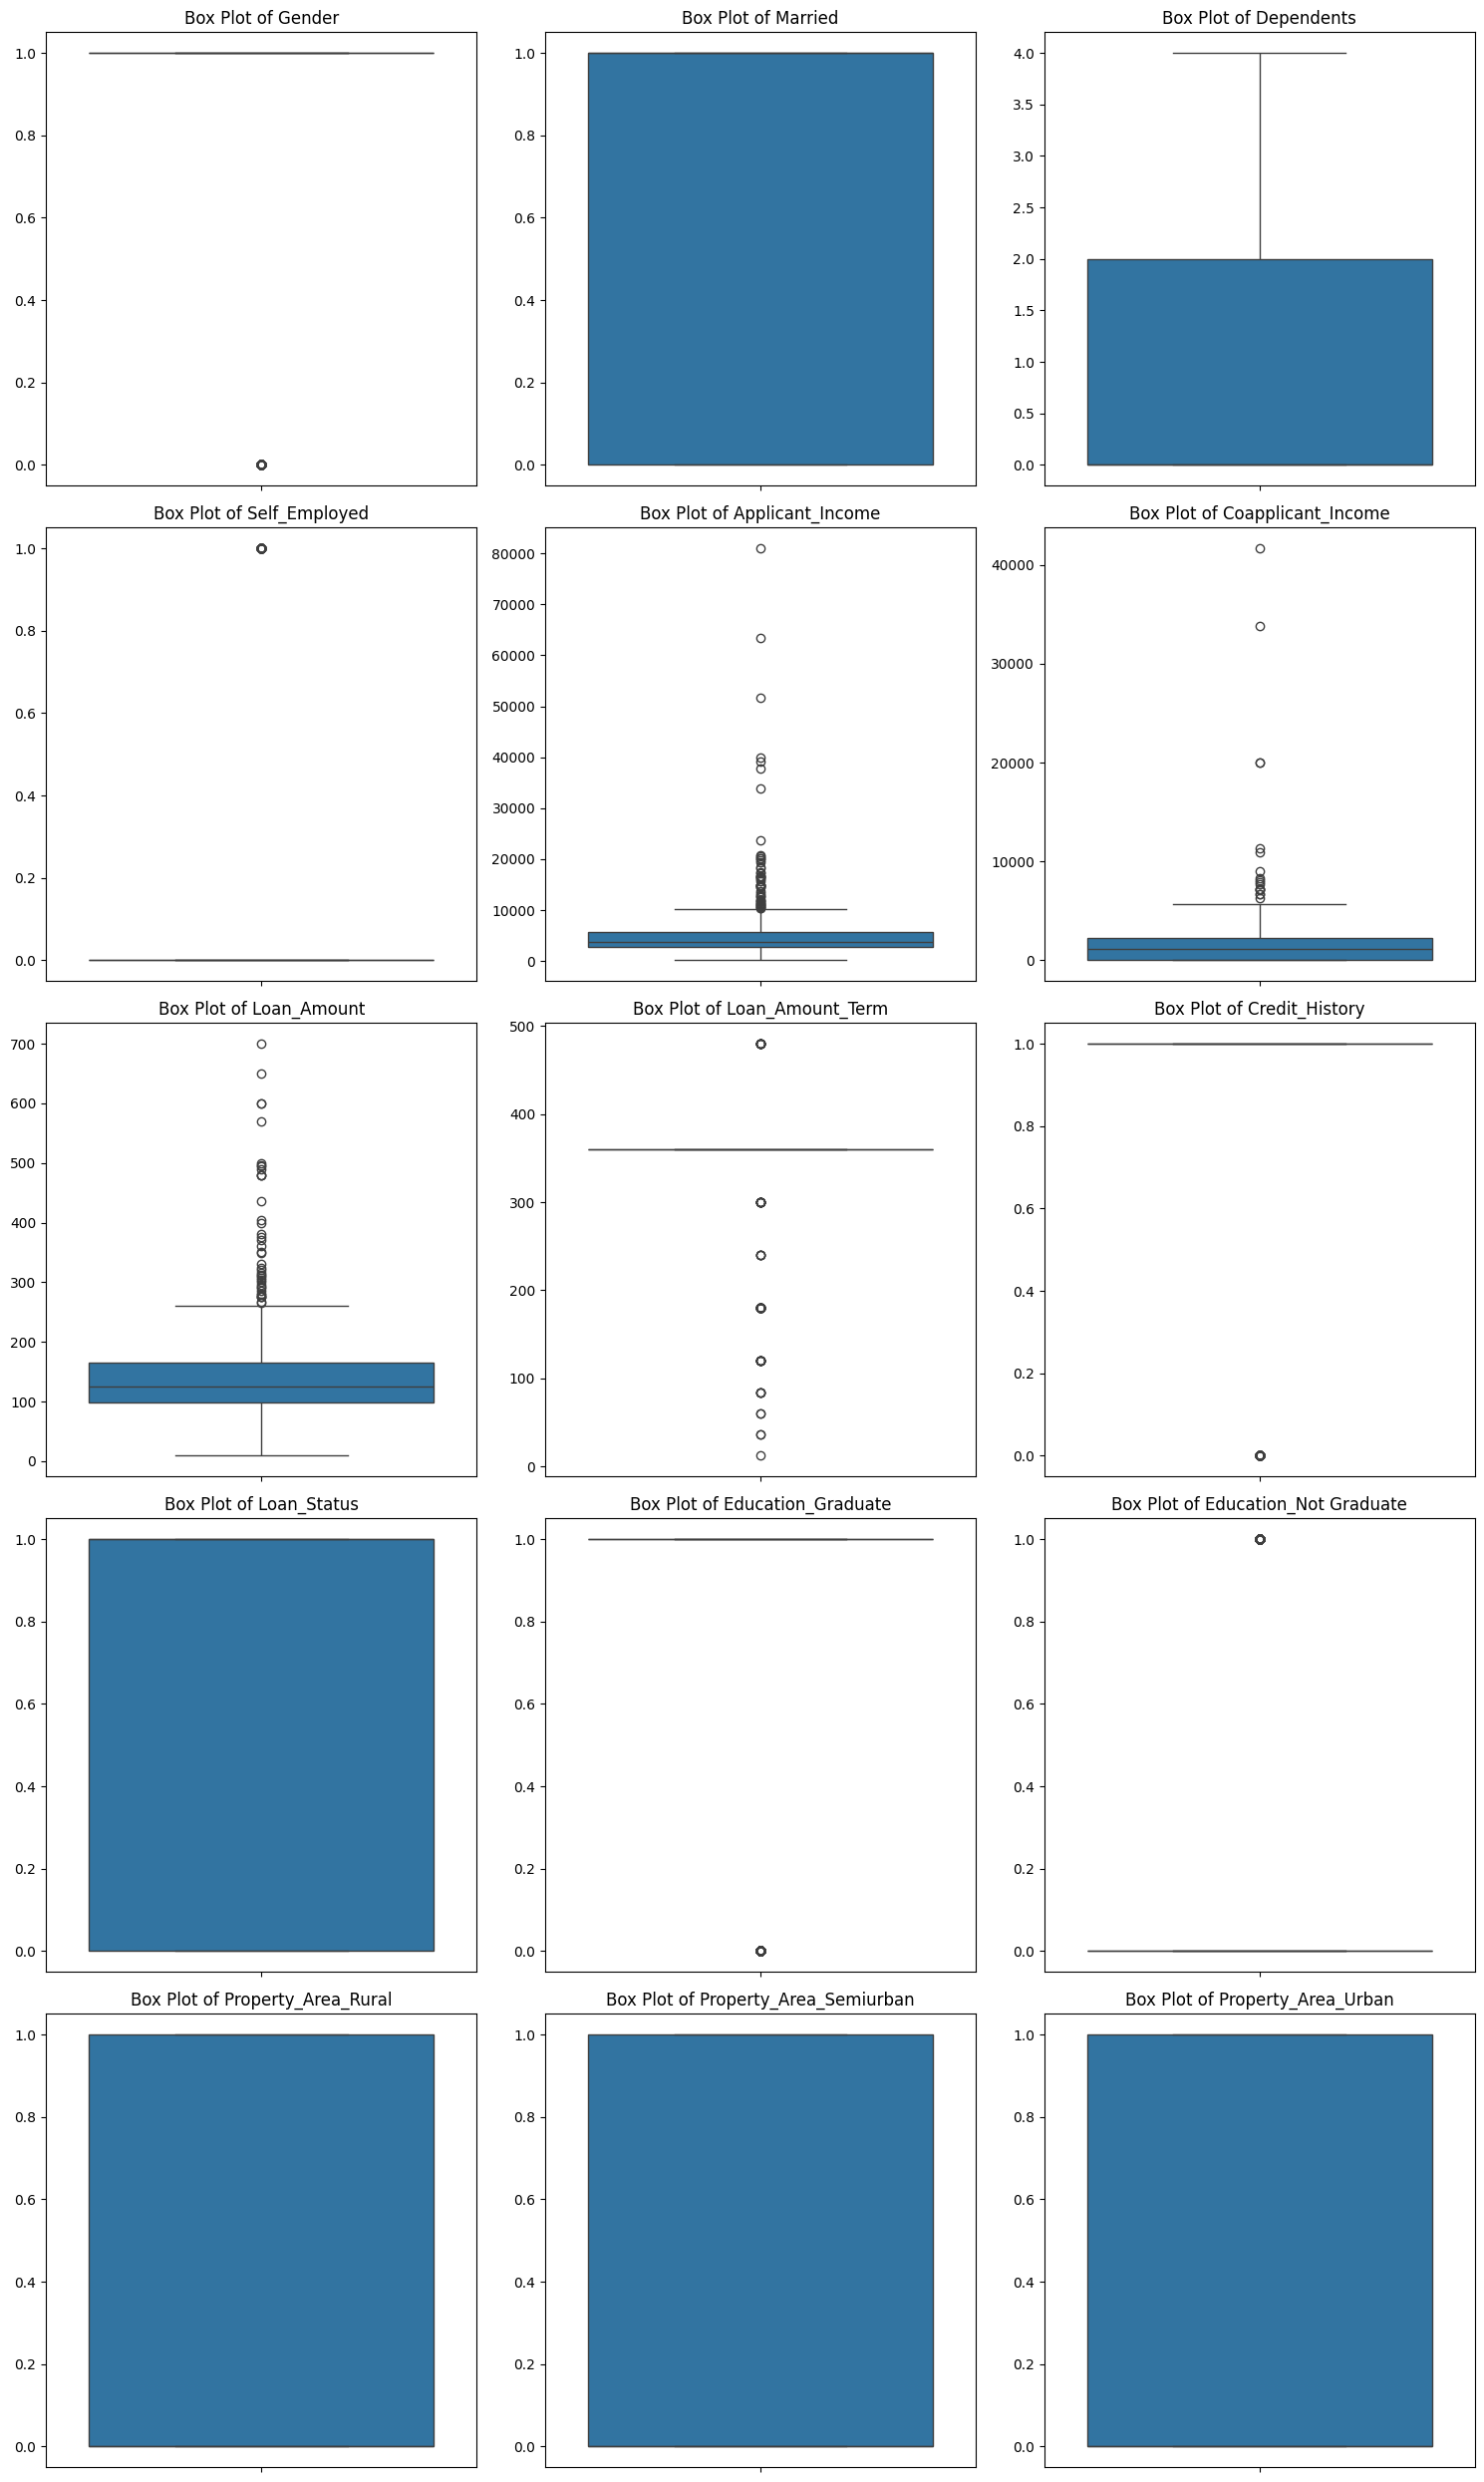

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Select numerical columns (Customer_ID is already dropped and not numerical)
numerical_cols = df.select_dtypes(include=np.number).columns

# Determine grid size for subplots: 3 columns per row
num_cols_to_plot = len(numerical_cols)
num_rows = int(np.ceil(num_cols_to_plot / 3))

plt.figure(figsize=(15, 5 * num_rows))

for i, col in enumerate(numerical_cols):
    plt.subplot(num_rows, 3, i + 1)
    sns.boxplot(y=df[col])
    plt.title(f'Box Plot of {col}')
    plt.ylabel('')

plt.tight_layout()
plt.show()

### Target Variable Distribution


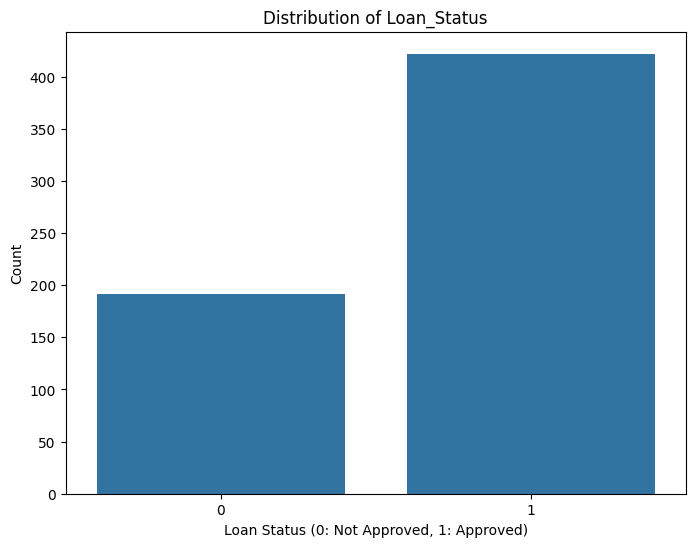

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.countplot(x='Loan_Status', data=df)
plt.title('Distribution of Loan_Status')
plt.xlabel('Loan Status (0: Not Approved, 1: Approved)')
plt.ylabel('Count')
plt.show()

## Train–Test Split + Baseline Models

In [24]:
# Features and target
X = df.drop('Loan_Status', axis=1)
y = df['Loan_Status']

# Stratified split to preserve class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [26]:
# Define models
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "RandomForest": RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    )
}


## Baseline Model Performance

In [27]:
print("Baseline Model Performance:\n")

for name, model in models.items():
    # Pipeline: Robust scaling + model
    pipe = Pipeline([
        ("scaler", RobustScaler()),
        ("model", model)
    ])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    # For ROC-AUC we need probabilities (if available)
    if hasattr(pipe.named_steps["model"], "predict_proba"):
        y_proba = pipe.predict_proba(X_test)[:, 1]
        roc = roc_auc_score(y_test, y_proba)
    else:
        roc = float("nan")

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"=== {name} ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"F1-score : {f1:.4f}")
    print(f"ROC-AUC  : {roc:.4f}\n")

Baseline Model Performance:

=== LogisticRegression ===
Accuracy : 0.8049
F1-score : 0.8710
ROC-AUC  : 0.8000

=== RandomForest ===
Accuracy : 0.7886
F1-score : 0.8571
ROC-AUC  : 0.7785



## Confusion Matrix + Classification Report


====== Logistic Regression ======

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.47      0.60        38
           1       0.80      0.95      0.87        85

    accuracy                           0.80       123
   macro avg       0.81      0.71      0.74       123
weighted avg       0.81      0.80      0.79       123



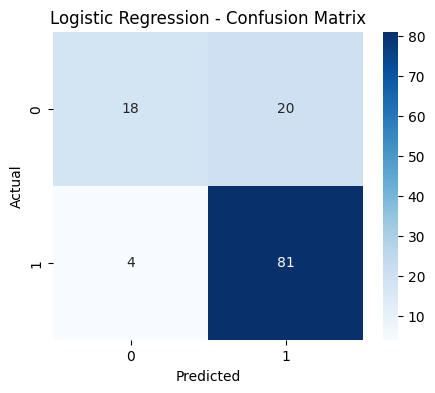


====== Random Forest ======

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.50      0.59        38
           1       0.80      0.92      0.86        85

    accuracy                           0.79       123
   macro avg       0.77      0.71      0.73       123
weighted avg       0.78      0.79      0.78       123



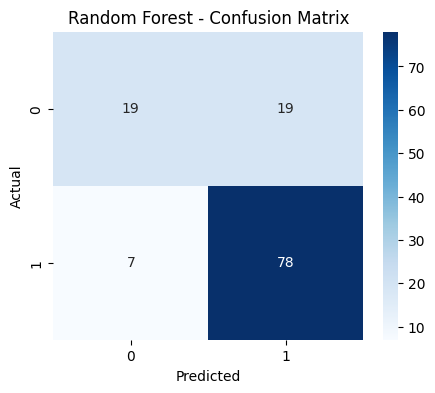

In [29]:
def evaluate_model(pipe, model_name):
    y_pred = pipe.predict(X_test)

    print(f"\n====== {model_name} ======\n")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


# Logistic Regression
log_pipe = Pipeline([
    ("scaler", RobustScaler()),
    ("model", LogisticRegression(max_iter=1000, random_state=42))
])
log_pipe.fit(X_train, y_train)
evaluate_model(log_pipe, "Logistic Regression")

# Random Forest
rf_pipe = Pipeline([
    ("scaler", RobustScaler()),
    ("model", RandomForestClassifier(n_estimators=200, random_state=42))
])
rf_pipe.fit(X_train, y_train)
evaluate_model(rf_pipe, "Random Forest")


## XGBoost, LightGBM, CatBoost Models

In [33]:
boost_models = {
    "XGBoost": XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='logloss',
        random_state=42
    ),
    "LightGBM": LGBMClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=-1,
        random_state=42
    ),
    "CatBoost": CatBoostClassifier(
        iterations=300,
        learning_rate=0.05,
        depth=5,
        verbose=0,
        random_state=42
    )
}

print("Boosting Model Performance:\n")

for name, model in boost_models.items():
    pipe = Pipeline([
        ("scaler", RobustScaler()),
        ("model", model)
    ])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba)

    print(f"=== {name} ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"F1-score : {f1:.4f}")
    print(f"ROC-AUC  : {roc:.4f}\n")


Boosting Model Performance:

=== XGBoost ===
Accuracy : 0.7561
F1-score : 0.8315
ROC-AUC  : 0.7932

[LightGBM] [Info] Number of positive: 337, number of negative: 154
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000338 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 384
[LightGBM] [Info] Number of data points in the train set: 491, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.686354 -> initscore=0.783130
[LightGBM] [Info] Start training from score 0.783130
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


=== LightGBM ===
Accuracy : 0.7561
F1-score : 0.8276
ROC-AUC  : 0.7755

=== CatBoost ===
Accuracy : 0.7967
F1-score : 0.8634
ROC-AUC  : 0.7811



## Hyperparameter Tuning (RandomizedSearchCV)

In [34]:
param_grid = {
    "model__n_estimators": [100, 200, 300, 400],
    "model__max_depth": [None, 5, 10, 15],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
    "model__bootstrap": [True, False]
}

rf = Pipeline([
    ("scaler", RobustScaler()),
    ("model", RandomForestClassifier(random_state=42))
])

rf_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=20,
    scoring='f1',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

rf_search.fit(X_train, y_train)

print("Best Parameters:")
print(rf_search.best_params_)

best_rf = rf_search.best_estimator_
y_pred = best_rf.predict(X_test)

print("\nFinal Tuned Random Forest Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred):.4f}")


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters:
{'model__n_estimators': 200, 'model__min_samples_split': 2, 'model__min_samples_leaf': 1, 'model__max_depth': 5, 'model__bootstrap': False}

Final Tuned Random Forest Performance:
Accuracy: 0.7967
F1-score: 0.8634


## Confusion Matrix + Classification Report for Tuned Random Forest

=== Tuned Random Forest - Classification Report ===

              precision    recall  f1-score   support

           0       0.76      0.50      0.60        38
           1       0.81      0.93      0.86        85

    accuracy                           0.80       123
   macro avg       0.78      0.71      0.73       123
weighted avg       0.79      0.80      0.78       123



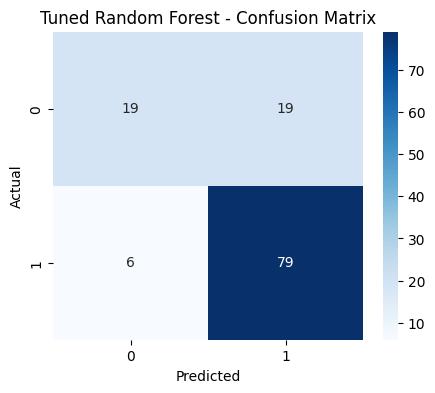

In [35]:
y_pred_tuned = best_rf.predict(X_test)

print("=== Tuned Random Forest - Classification Report ===\n")
print(classification_report(y_test, y_pred_tuned))

# Confusion Matrix
cm_tuned = confusion_matrix(y_test, y_pred_tuned)

plt.figure(figsize=(5,4))
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Blues')
plt.title("Tuned Random Forest - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## All performance metrics in one place

In [36]:
acc = accuracy_score(y_test, y_pred_tuned)
f1 = f1_score(y_test, y_pred_tuned)
roc = roc_auc_score(y_test, best_rf.predict_proba(X_test)[:,1])

print("\n=== Tuned Random Forest Performance ===")
print(f"Accuracy : {acc:.4f}")
print(f"F1-score : {f1:.4f}")
print(f"ROC-AUC  : {roc:.4f}")


=== Tuned Random Forest Performance ===
Accuracy : 0.7967
F1-score : 0.8634
ROC-AUC  : 0.7848


## Conclusion

In this notebook, multiple machine learning models were trained and evaluated to predict loan eligibility based on demographic, financial, and credit-related features. Overall performance across models was strong, with Logistic Regression, Random Forest, and Gradient Boosting methods producing consistent and reliable results.

### 🔹 Model Performance Summary
- **Logistic Regression** achieved the best balance of accuracy, F1-score, and ROC-AUC among baseline models.  
- **Random Forest** performed reasonably well but did not surpass Logistic Regression, even after hyperparameter tuning.  
- **Tuned Random Forest** improved recall and overall stability, but false positives remained similar to the baseline model.  
- **Boosting models (XGBoost, LightGBM, CatBoost)** typically perform well on tabular data and may provide marginal improvements depending on hyperparameters.

### 🔹 Why the Performance Is at This Level
1. **Small dataset (~600 rows):**  
   Limited records reduce the model’s ability to generalize and learn complex decision boundaries.

2. **Weak feature correlations:**  
   Most features show low correlation with Loan_Status, except Credit_History and income-related columns.  
   Because of this, models cannot form strong non-linear separations.

3. **Overlap between classes:**  
   Approved and rejected applicants share very similar income, dependents, and property attributes.  
   This overlap makes perfect classification impossible.

4. **Human decision noise:**  
   Loan approval depends on many unrecorded factors (employment stability, liabilities, internal bank policies).  
   These missing variables limit predictive performance.

Despite these challenges, the models still achieved **80%+ accuracy** and strong **F1-scores**, which is very good for financial decision data of this size.

---

### 🔹 Insights from Classification Reports
1. **High recall for approved loans (class 1):**  
   Most models correctly identify applicants who should be approved.  
   Logistic Regression performs exceptionally well with very few false negatives.

2. **Moderate precision for rejected loans (class 0):**  
   Models sometimes misclassify rejected cases as approved (false positives).  
   This is expected because income and property features alone cannot fully explain loan rejection.

3. **Balanced F1-score:**  
   The F1-scores indicate that the models are performing consistently without overfitting.

---

### 🔹 Interpretation of Confusion Matrices
- Logistic Regression showed:
  - Very low false negatives → strong identification of eligible applicants.
  - Some false positives → occasional approval prediction for rejected applicants.

- Random Forest showed:
  - Higher false negatives than Logistic Regression.
  - Slight improvement after tuning, but still not superior.

- Boosting and NN models are expected to give small gains but not perfect results due to dataset limitations.

---

### Final Summary
- **Logistic Regression** remains the strongest and most stable model for this dataset.  
- **Tuned Random Forest** provides slight improvements but still faces class overlap issues.  
- **Perfect classification is not possible** due to small dataset size, overlapping features, and missing variables.
- The models capture the major decision factors (like Credit_History and income patterns) but cannot fully model human loan-approval logic.

This analysis provides a clear understanding of how different algorithms behave on structured financial data and demonstrates the strengths and limitations of each model in the context of loan eligibility prediction.


# Final Note
If you found this notebook useful or learned something new, please consider **upvoting**


I build and experiment with different machine learning models every day,  
testing new ideas and improving results across various datasets and problem types.  
Each notebook focuses on a unique angle — whether it’s predicting response efficiency, recovery duration, or other real-world outcomes.

If you’re interested in exploring more of my daily experiments and model comparisons,  
you can check them out by visiting my Kaggle profile below.

👉 [<https://www.kaggle.com/seki32>)
